In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydicom
!pip install Pillow
!pip install efficientnet_pytorch
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached n

In [3]:
import os
import shutil
import pandas as pd
import pydicom
from PIL import Image
import numpy as np
import torch
from fastai.vision.all import *
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import timm
import matplotlib.pyplot as plt

In [4]:
train_folder = "/content/drive/MyDrive/DP4_final/train"
test_folder = "/content/drive/MyDrive/DP4_final/test"

if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

def convert_dcm_to_jpg(file_path, output_folder, processed_files, total_files):
    ds = pydicom.dcmread(file_path)
    img = ds.pixel_array
    img = (img / img.max()) * 255
    img = img.astype(np.uint8)
    img = Image.fromarray(img)
    width_percent = (512/float(img.size[0]))
    new_height = int((float(img.size[1])*float(width_percent)))
    img = img.resize((512, new_height), Image.ANTIALIAS)
    new_filename = os.path.splitext(os.path.basename(file_path))[0] + '.jpg'
    new_file_path = os.path.join(output_folder, new_filename)
    img.save(new_file_path)

    print(f'Successfully converted image {processed_files} of {total_files} and saved as {new_file_path}')


df = pd.read_csv('/content/drive/MyDrive/DP4/train_revalidado1.csv')
total_files = len(os.listdir('/content/drive/MyDrive/DP4/train'))

In [ ]:
#código para transformar y guardar imágenes
processed_files = 0

for index, row in df.iterrows():
    image_name = str(row[0]) + '.dcm'
    class_name = str(row[1])

    class_folder = os.path.join(train_folder, class_name)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

    if os.path.exists(f'/content/drive/MyDrive/DP4/train/{image_name}'):
        file_path = f'/content/drive/MyDrive/DP4/train/{image_name}'
    else:
        print(f'File {image_name} not found in train folder. Skipping...')
        continue

    processed_files += 1
    convert_dcm_to_jpg(file_path, class_folder, processed_files, total_files)


total_files = len(os.listdir('/content/drive/MyDrive/DP4/test'))
processed_files = 0

for filename in os.listdir('/content/drive/MyDrive/DP4/test'):
    if filename.endswith(".dcm"):
        file_path = os.path.join('/content/drive/MyDrive/DP4/test', filename)
        processed_files += 1
        convert_dcm_to_jpg(file_path, test_folder, processed_files, total_files)

In [6]:
path = "/content/drive/MyDrive/DP4_final"
batch_size = 4  # Reduce el batch size para modelos más grandes
size = 256

def oversample_data(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_oversampled, y_oversampled = oversampler.fit_resample(X, y)
    return X_oversampled, y_oversampled

# Define EfficientNet model architectures
efficientnet_archs = ['efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4']

# Prepare the data
dls = ImageDataLoaders.from_folder(
    path=path + '/train',
    test=path + '/test',
    valid_pct=0.2,
    ds_tfms=aug_transforms(),
    size=size,
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    item_tfms=Resize(size, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    bs=batch_size,
    shuffle=True
)

# Oversample the training data
y_train = np.array([dls.train_ds.items[i].parent.name for i in range(len(dls.train_ds))])
y_train_indices = np.arange(len(y_train)).reshape(-1, 1)
_, y_train_oversampled = oversample_data(y_train_indices, y_train)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_oversampled), y=y_train_oversampled)
class_weights = torch.FloatTensor(class_weights).cuda()

# Check the number of classes in your dataset
num_classes = len(np.unique(y_train_oversampled))

# Adjust class weights to match the number of classes if needed
if len(class_weights) != num_classes:
    class_weights = torch.ones(num_classes).cuda()

In [8]:
dls.vocab

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9']

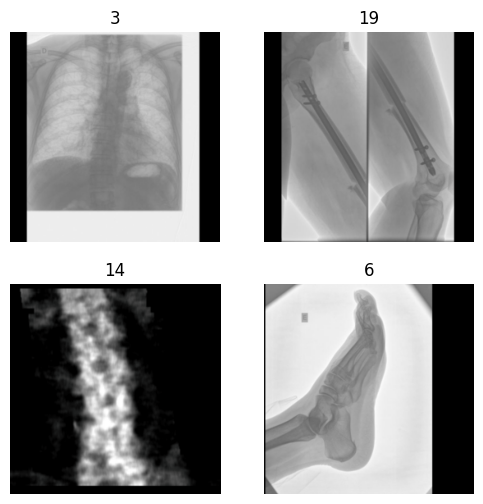

In [21]:
dls.show_batch()

epoch,train_loss,valid_loss,accuracy,time
0,1.152545,0.668768,0.811765,00:21
1,0.525715,0.487752,0.878431,00:21
2,0.899398,1.323352,0.725490,00:21
3,0.731474,1.381343,0.725490,00:21
4,0.520296,0.544741,0.870588,00:21
5,0.573613,1.013388,0.709804,00:21
6,0.470677,0.725063,0.854902,00:21
7,0.300134,0.694810,0.839216,00:21
8,0.356705,0.610900,0.886275,00:21
9,0.233521,0.441482,0.917647,00:21


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


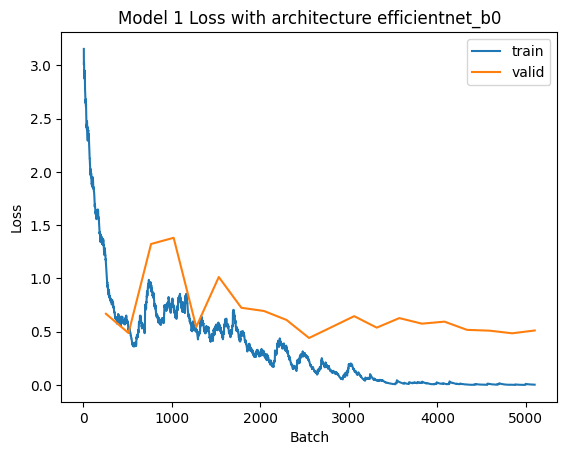

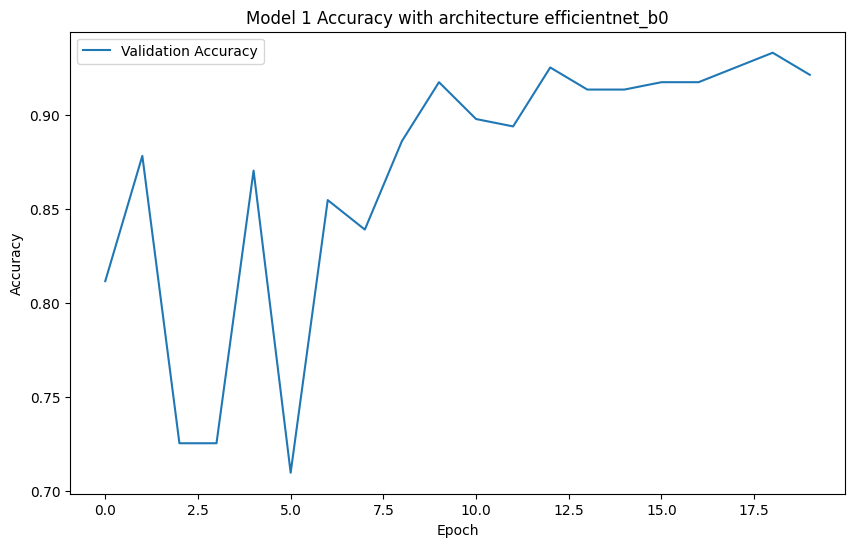

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,1.096375,0.634527,0.850980,00:28
1,0.627786,0.612311,0.835294,00:29
2,0.575557,0.543757,0.874510,00:29
3,0.592601,0.519980,0.850980,00:29
4,0.555888,0.642837,0.858824,00:28
5,0.485408,0.461501,0.898039,00:28
6,0.367251,0.818393,0.819608,00:28
7,0.299593,0.476957,0.917647,00:28
8,0.184429,0.662850,0.905882,00:29
9,0.164308,0.591613,0.901961,00:29


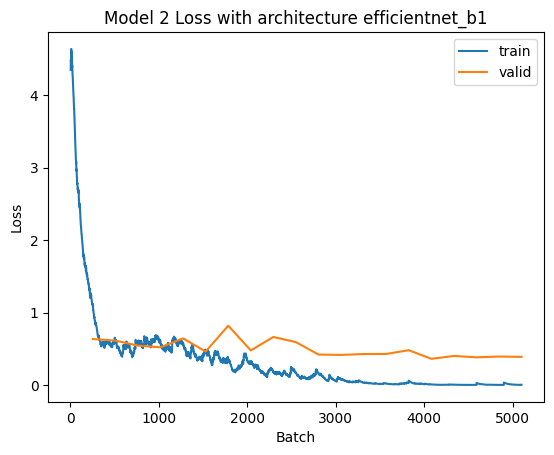

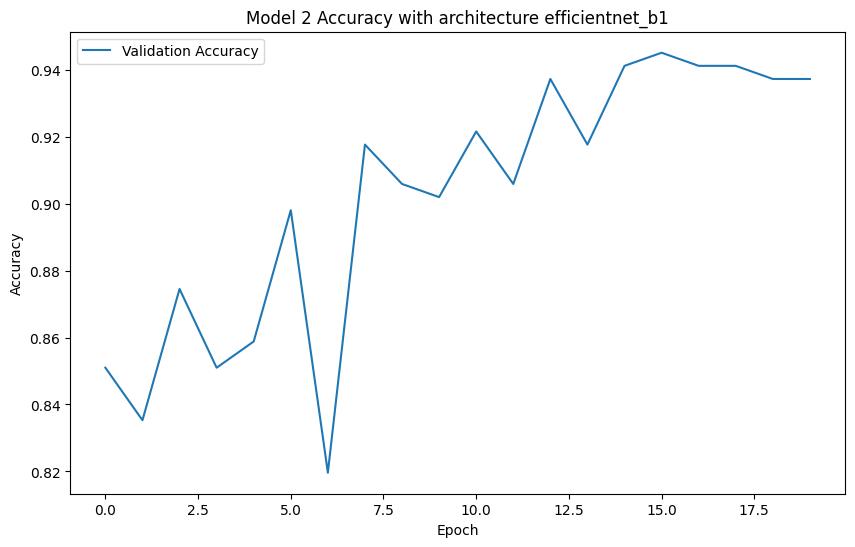

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.040852,0.612630,0.827451,00:29
1,0.721571,0.530229,0.839216,00:29
2,0.784082,0.615957,0.858824,00:29
3,0.598695,1.297621,0.819608,00:29
4,0.819546,0.862650,0.745098,00:29
5,0.514747,1.017056,0.839216,00:29
6,0.524578,0.553368,0.874510,00:29
7,0.357179,0.645413,0.862745,00:29
8,0.312120,0.509253,0.874510,00:29
9,0.130629,0.460652,0.909804,00:29


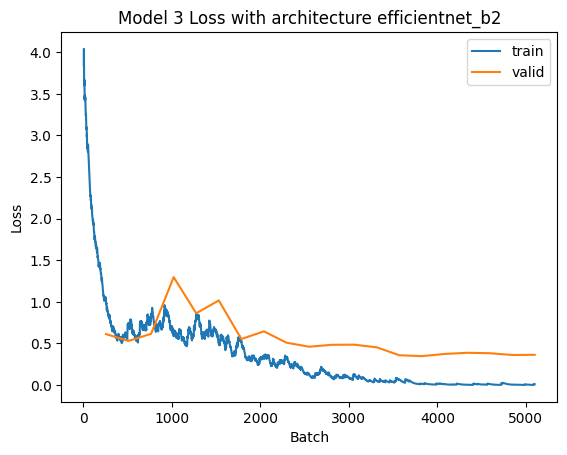

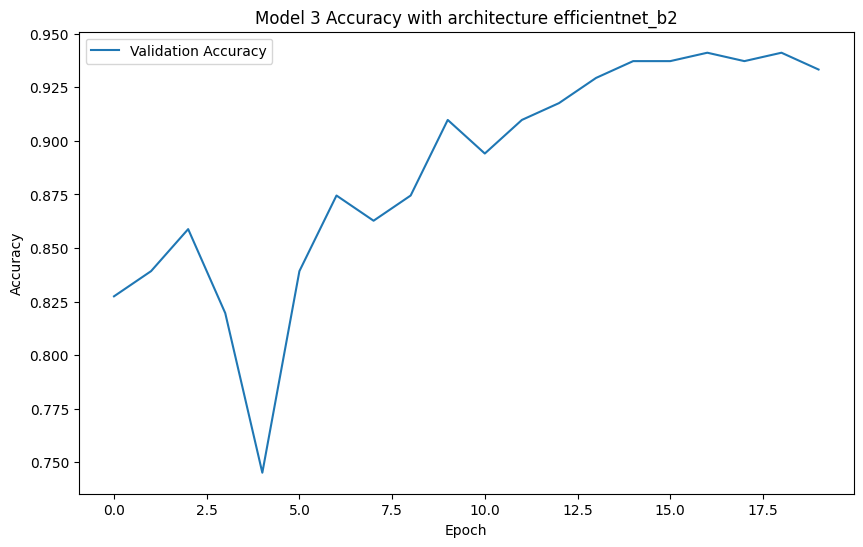

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.145700,2.336911,0.800000,00:33
1,0.602042,0.616479,0.843137,00:33
2,0.645376,0.480222,0.886275,00:33
3,0.548049,0.528887,0.866667,00:33
4,0.645837,1.479430,0.713726,00:33
5,0.448624,0.403307,0.898039,00:33
6,0.360719,0.932914,0.835294,00:33
7,0.339457,0.493156,0.901961,00:33
8,0.188058,1.539071,0.858824,00:33
9,0.143035,0.704758,0.898039,00:33


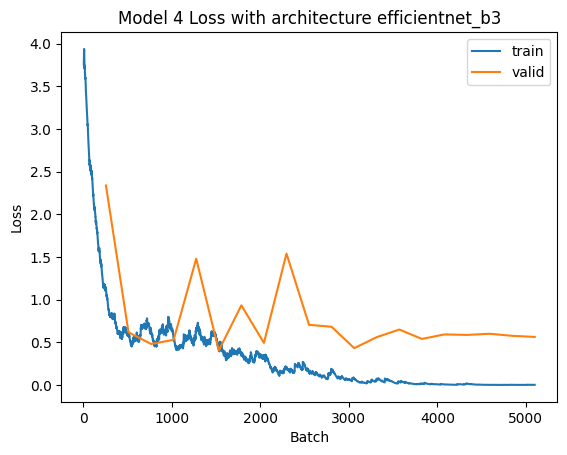

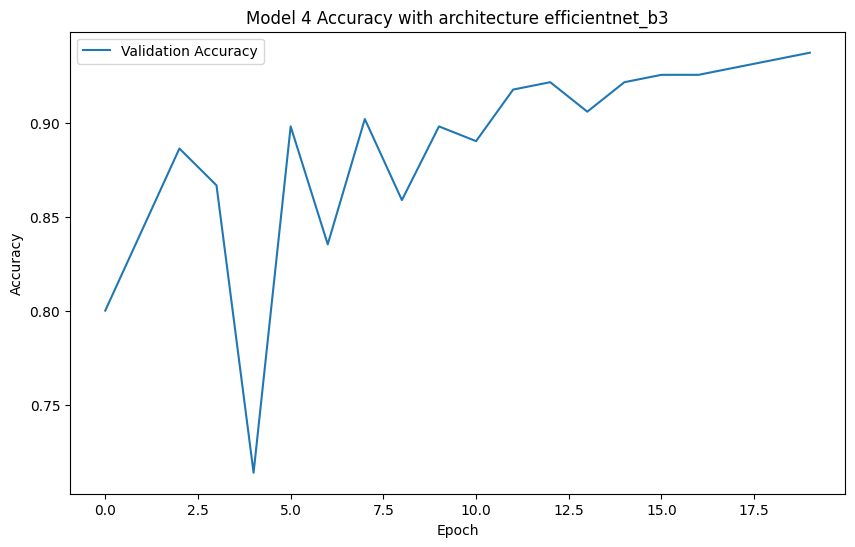

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.527324,1.371662,0.686275,00:40
1,0.563688,0.418856,0.905882,00:40
2,0.353555,0.383312,0.894118,00:40
3,0.289600,0.350905,0.921569,00:40
4,0.210064,0.607032,0.894118,00:40
5,0.327324,0.429346,0.909804,00:40
6,0.118464,0.504699,0.925490,00:40
7,0.105937,0.448581,0.917647,00:40
8,0.064099,0.496530,0.921569,00:40
9,0.183764,0.514990,0.921569,00:40


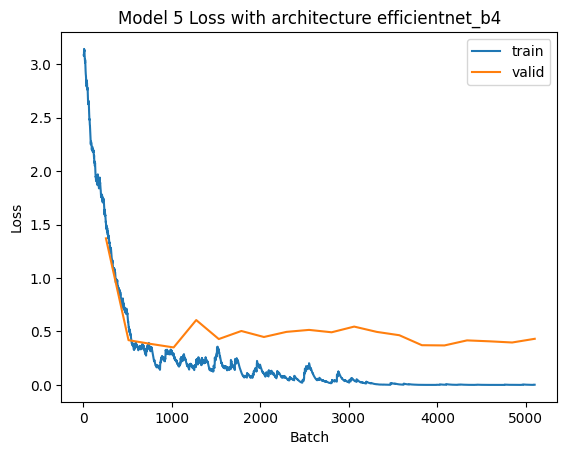

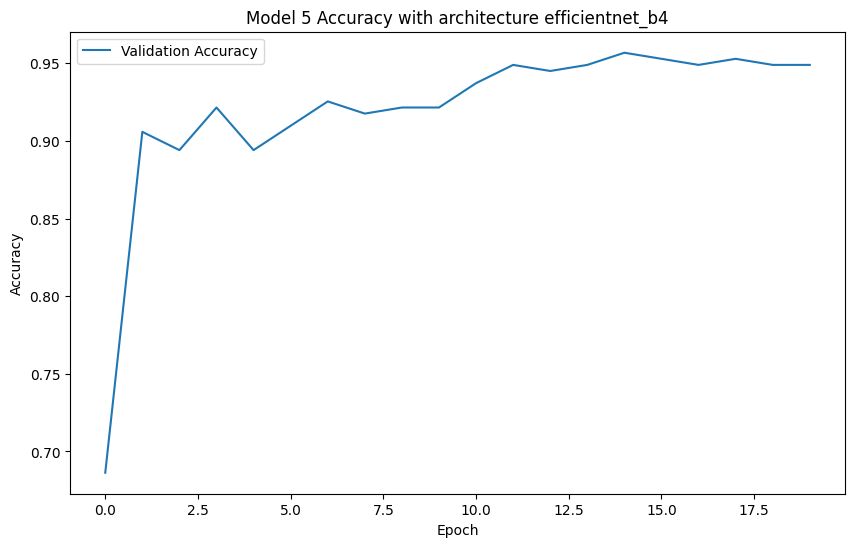

In [22]:
# Create and train the models
models = []
for i, arch in enumerate(efficientnet_archs):
    model = timm.create_model(arch, pretrained=True, num_classes=dls.c)
    learner = Learner(dls, model, loss_func=nn.CrossEntropyLoss(weight=class_weights), metrics=accuracy).to_fp16()  # Use mixed precision training

    # Train the model
    learner.fit_one_cycle(20)

    # Display training results
    learner.recorder.plot_loss()
    plt.title(f'Model {i+1} Loss with architecture {arch}')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(10,6))
    valid_acc = [x[2] for x in learner.recorder.values]
    plt.plot(valid_acc, label='Validation Accuracy')
    plt.title(f'Model {i+1} Accuracy with architecture {arch}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    models.append(learner)


In [23]:
test_items = get_image_files("/content/drive/MyDrive/DP4_final/test")
test_dl = dls.test_dl(test_items)


In [24]:
preds = []
for model in models:
    pred, _ = model.get_preds(dl=test_dl)
    preds.append(pred)

In [25]:
# Get TTA predictions for each model
preds = [model.tta(dl=test_dl, n=64, use_max=False)[0] for model in models]

# Average predictions
avg_preds = torch.mean(torch.stack(preds), dim=0)

# Get class indices
class_idxs = avg_preds.argmax(dim=-1)

# Get class labels
class_labels = [dls.vocab[i] for i in class_idxs]

# Get image ids from test set
image_ids = [item.stem for item in test_items]

# Create a DataFrame for submission
submission_df = pd.DataFrame({'SOPInstanceUID': image_ids, 'Target': class_labels})

# Save DataFrame to a CSV file
submission_df.to_csv('prueba_eff4av.csv', index=False)

# Print a message
print("Submission file has been written to 'prueba_eff4av.csv'")

Submission file has been written to 'prueba_eff4av.csv'
